In [43]:
import numpy as np
import matplotlib.pyplot as plt
%run IDM_helper_functions.ipynb

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

In [2]:
W_pos, W_neg = 52500, 8400
B1, B2 = 0, 0
N, theta = 2000, 51450

y1, y2 = 0.2, 0.2
beta=1/24
print(energy(y1,y2))
print(dEdy1(y1, y2, W_pos, W_neg, B1, theta))
print(dEdy2(y1,y2, W_pos, W_neg, B2, theta))
print(free_energy(y1,y2,N=2000))
print(dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N))
print(dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N))

16716.0
32130.0
32130.0
-7303.316329833018
-1141.064666877377
-1141.064666877377


In [33]:
# Training data
num_simulations = 50000
prior = utils.BoxUniform(low=[0.1,0.2,0.1], high=[1.2,0.6,0.6])
parameters = prior.sample((num_simulations,))
x = simul_IDM_EM_three_param(np.array(parameters))

In [34]:
# Train MNLE and obtain MCMC-based posterior.

trainer = MNLE(prior=prior)
trainer = trainer.append_simulations(parameters, x)
mnle = trainer.train()


 Neural network successfully converged after 58 epochs.

In [6]:
#
mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")

#mcmc_parameters=dict(init_strategy="resample", num_chains=10, warmup_steps=100)


mnle_posterior = trainer.build_posterior(mnle, prior)


In [8]:
# inference with different x_o that has 100 trials
torch.manual_seed(41)
num_trials = 100
num_samples = 100
parameters_o = prior.sample((1,))
x_o = simul_IDM_EM_three_param(np.array(parameters_o.repeat(num_trials, 1)))

In [9]:
mnle_posterior = trainer.build_posterior(mnle, prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

/Users/wangjiashun/Documents/GitHub/sbi/sbi/utils/sbiutils.py:321: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

/Users/wangjiashun/Documents/GitHub/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


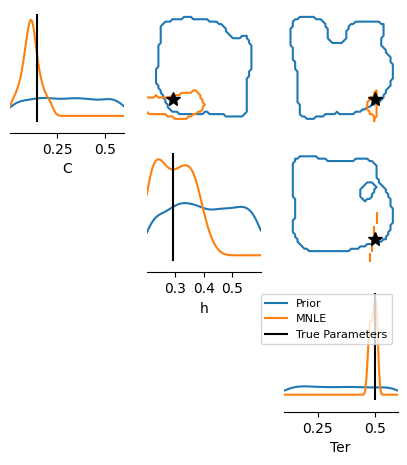

In [10]:
#pair_plot(prior, mnle_samples, parameters_o, 
contour = 0.7

fig, ax = pairplot(
    [
        prior.sample((1000,)),
        mnle_samples,
    ],
    points=parameters_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[contour]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=['C', 'h','Ter'],
    figsize=(5, 5)
)

#plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "MNLE", 'True Parameters'],
    #frameon=False,
    fontsize=8,
    loc = 1
);

In [13]:
# inference with different x_o that has 100 trials
torch.manual_seed(41)
num_trials = 100
num_samples = 100
parameters_o = prior.sample((1,))
x_o = simul_IDM_EM_three_param(np.array(parameters_o.repeat(num_trials, 1)))
mnle_posterior = trainer.build_posterior(mnle, prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

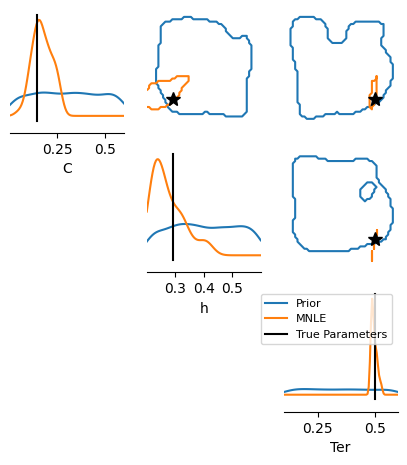

In [14]:
#pair_plot(prior, mnle_samples, parameters_o, 

pair_plot(prior, mnle_samples, parameters_o, contour = 0.7, labels=['C', 'h','Ter'])

### Simulate and Fit

In [50]:
Vs = np.random.uniform(low=0, high=3, size=30)
As = np.random.uniform(low=0.4, high=0.9, size=30)
Ters = np.random.uniform(low=0.1, high=0.7, size=30)

n_trials = 100
num_samples = 100
par_fitted = np.zeros((30,3))



In [51]:
for i in range(len(Vs)):
    print(i)
    v,a,ter = Vs[i], As[i], Ters[i]
    DDM_o = simul_DDM(np.tile((Vs[i], As[i], Ters[i]), (n_trials,1)), c = 0.05) # simulate IDM data
    
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(DDM_o)
    mnle_map = mnle_posterior.map()
    
    par_fitted[i,:] = np.array(mnle_map)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


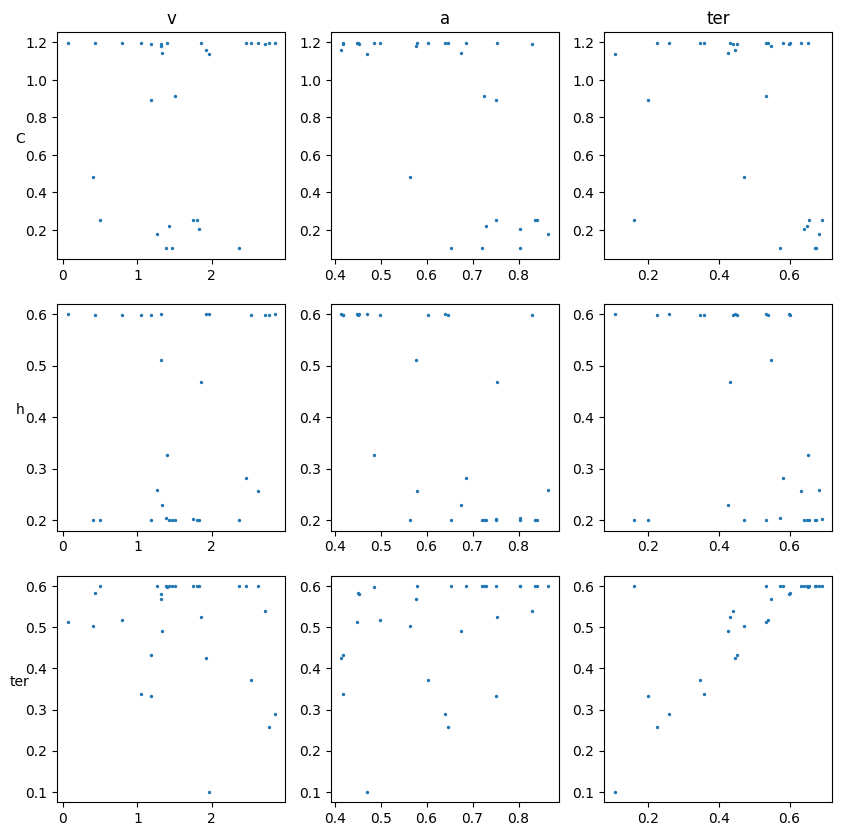

In [53]:
sim_fit_plot(Vs, As, Ters, par_fitted, sim_num = 30)

In [ ]:
Vs = np.random.uniform(low=0, high=3, size=30)
As = np.random.uniform(low=0.4, high=0.9, size=30)
Ters = np.random.uniform(low=0.1, high=0.7, size=30)

n_trials = 200
num_samples = 100
par_fitted = np.zeros((30,3))

In [ ]:
for i in range(len(Vs)):
    print(i)
    v,a,ter = Vs[i], As[i], Ters[i]
    DDM_o = simul_DDM(np.tile((Vs[i], As[i], Ters[i]), (n_trials,1)), c = 0.01) # simulate IDM data
    
    #prior = utils.BoxUniform(low=[0,0.2,0.1], high=[0.5,0.6,0.6])
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(DDM_o)
    mnle_map = mnle_posterior.map()
    
    par_fitted[i,:] = np.array(mnle_map)

In [ ]:
sim_num = 22
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

ax1.scatter(Vs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax3.scatter(Ters[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax4.scatter(Vs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax6.scatter(Ters[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax7.scatter(Vs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax9.scatter(Ters[0:sim_num], par_fitted[0:sim_num,2], s = 2)

ax1.set_title("v")
ax2.set_title("a")
ax3.set_title("ter")

ax1.set_ylabel("C", rotation=0)
ax4.set_ylabel("h", rotation=0)
ax7.set_ylabel("ter", rotation=0)

In [ ]:
Vs = np.random.uniform(low=0, high=3, size=30)
As = np.random.uniform(low=0.4, high=0.9, size=30)
Ters = np.random.uniform(low=0.1, high=0.7, size=30)

n_trials = 200
num_samples = 100
par_fitted = np.zeros((30,3))




for i in range(len(Vs)):
    print(i)
    v,a,ter = Vs[i], As[i], Ters[i]
    DDM_o = simul_DDM(np.tile((Vs[i], As[i], Ters[i]), (n_trials,1)), c = 0.1) # simulate IDM data
    
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(DDM_o)
    mnle_map = mnle_posterior.map()
    
    par_fitted[i,:] = np.array(mnle_map)
    
    

In [ ]:
sim_num = 30
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

ax1.scatter(Vs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax3.scatter(Ters[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax4.scatter(Vs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax6.scatter(Ters[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax7.scatter(Vs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax9.scatter(Ters[0:sim_num], par_fitted[0:sim_num,2], s = 2)

ax1.set_title("v")
ax2.set_title("a")
ax3.set_title("ter")

ax1.set_ylabel("C", rotation=0)
ax4.set_ylabel("h", rotation=0)
ax7.set_ylabel("ter", rotation=0)

In [ ]:
Vs = np.random.uniform(low=0, high=3, size=30)
As = np.random.uniform(low=0.4, high=0.9, size=30)
Ters = np.random.uniform(low=0.1, high=0.7, size=30)

n_trials = 200
num_samples = 100
par_fitted = np.zeros((30,3))

for i in range(len(Vs)):
    print(i)
    v,a,ter = Vs[i], As[i], Ters[i]
    DDM_o = simul_DDM(np.tile((Vs[i], As[i], Ters[i]), (n_trials,1)), c = 1) # simulate IDM data
    
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(DDM_o)
    mnle_map = mnle_posterior.map()
    
    par_fitted[i,:] = np.array(mnle_map)
    
    

In [ ]:
sim_num = 30
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

ax1.scatter(Vs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax3.scatter(Ters[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax4.scatter(Vs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax6.scatter(Ters[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax7.scatter(Vs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax9.scatter(Ters[0:sim_num], par_fitted[0:sim_num,2], s = 2)

ax1.set_title("v")
ax2.set_title("a")
ax3.set_title("ter")

ax1.set_ylabel("C", rotation=0)
ax4.set_ylabel("h", rotation=0)
ax7.set_ylabel("ter", rotation=0)